# Vizzuality coding challenge

The below code explores the dataset pertaining to the Vizzuality coding challange.
More information can be found on: https://github.com/Vizzuality/science-code-challenge/blob/main/README.md

Lets start by importing the required libraries:

In [4]:
# import libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import os
import warnings
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import folium

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
pd.set_option('max_columns', 20)

Now let's download the main dataset!

This is the location of the file:
https://s3.amazonaws.com/mapspam/2010/v2.0/csv/spam2010v2r0_global_phys_area.csv.zip -- contains 6 further csv files. We will be focusing on the "TA" file - all technologies together, ie complete crop or crop group

Check out the README file for the dataset: https://s3.amazonaws.com/mapspam/2010/v1.1/readme_v1r1_global.txt

In [5]:
# get the data

data = pd.read_csv('./spam2010v2r0_global_phys_area.csv/spam2010V2r0_global_A_TA.csv', encoding='latin1')

In [6]:
# check that the data loads well

data.head()

,iso3,prod_level,alloc_key,cell5m,x,y,rec_type,tech_type,unit,whea_a,...,trof_a,temf_a,vege_a,rest_a,crea_date,year_data,source,name_cntr,name_adm1,name_adm2
0,CHN,CH08078,4383640,1891479,123.291667,53.541667,A,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
1,CHN,CH08078,4393627,1895786,122.208333,53.458333,A,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
2,CHN,CH08078,4393628,1895787,122.291667,53.458333,A,A,ha,0.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
3,CHN,CH08078,4393629,1895788,122.375000,53.458333,A,A,ha,5.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian
4,CHN,CH08078,4393637,1895796,123.041667,53.458333,A,A,ha,1.0,...,0.0,0.0,0.0,0.0,04/24/20 07:04:41 PM,avg(2009-2011),F avg2,China,Heilongjiang,Mohexian


### Explore the dataset
Lets just first explore the dataset to learn more about it and do some quality checks

In [7]:
# We are really only interested in soybean production so in how many grids do we have soya being produced? 
soya_presence = data[data.soyb_a > 0]
round(len(soya_presence) / len(data), 3)

0.415

Around 41.5% of all the pixels have some soya being produced!

In [8]:
# what year does our data really cover (focusing only the grids where soya is made)?
year_counts = soya_presence.groupby('year_data').size().reset_index()
year_counts.rename(columns={0:'count'}, inplace=True)
year_counts['percentage'] = (year_counts['count'] / year_counts['count'].sum())
print(year_counts.sort_values(by = 'percentage', ascending=False).head(10))

          year_data   count  percentage
20   avg(2009-2011)  251115    0.730523
12  avg(09-11), som   16292    0.047395
13    avg(09-11),02   13860    0.040320
23   avg(2010-2012)   12068    0.035107
8     avg(07,09-12)    7864    0.022877
11       avg(09-11)    5874    0.017088
22     avg(2010,11)    4748    0.013812
3              2010    4319    0.012564
6              2013    4022    0.011700
21   avg(2009_2011)    3297    0.009591


Good to see that 73% of the data is the average from 2009-2011. But there area some other years that seem to have some formatting issues.

In [9]:
# year_data and iso3 interplay ... any country that has more than one unique 'year_data' associated to it?
iso_year = soya_presence.groupby(['iso3']).agg({'year_data':'nunique'}).reset_index()
print(max(iso_year.year_data)) 

1


We see that each country is only covered by 1 unique year value, which is reasurring. That means that the formatting issues are country specific, but in the end, should not be an issue.

<AxesSubplot:>

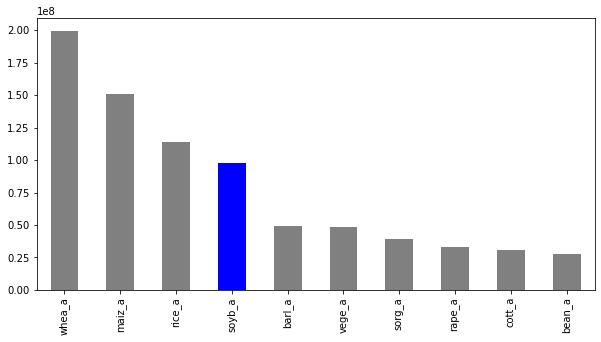

In [10]:
# A simple bar chart to see where soybean production stacks up against the other crops
data.iloc[:,9:51].sum().sort_values(ascending=False).head(10).plot(kind = 'bar', figsize=(10, 5), color = ['grey', 'grey', 'grey', 'b', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey'])


Whithin this dataset, soybean is the 4th most produced crop! That's a lot of protein!

### Creating a few new measures that help us understand the dynamics of soybean production in light of the total crop production within the grid

In [11]:
# Percent of soy bean production from total crop production
# so a measure of 1 means only soy bean is produced in the 10x10km square
# this is to understand whether the soybean production is a monoculture or whether it is in a more mixed culture
# columns 9-51 are all our measures

# sum up the total crop production in the grid
soya_presence['total_production'] = soya_presence.iloc[:, 9:51].sum(axis=1)
# calculate the soybean production % of total production
soya_presence['soyb_percent'] = soya_presence['soyb_a'] / soya_presence['total_production']

In [12]:
# create a measure to calculate the % of total area that is used for crop production
# i.e. a measure of 1 means the whole 10x10km square (= 10 000ha) is used for crop production
# this is simply to understand the scale of the crop production within the grid
# DISCLAIMER: we only have the centroids of the grid, ultimately, we would want the polygons so we could calculate the
# surface area of each grid mora accurately.
soya_presence['total_production_percent'] = soya_presence['total_production'] / 10000 

In [13]:
soya_presence.tail()

,iso3,prod_level,alloc_key,cell5m,x,y,rec_type,tech_type,unit,whea_a,...,rest_a,crea_date,year_data,source,name_cntr,name_adm1,name_adm2,total_production,soyb_percent,total_production_percent
832728,USA,US10043,7751196,3344875,-80.375000,25.458333,A,A,ha,0.1,...,0.0,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,126.8,0.014196,0.01268
832729,USA,US10043,7761192,3349191,-80.708333,25.375000,A,A,ha,0.1,...,0.0,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,5.0,0.100000,0.00050
832731,USA,US10043,7761194,3349193,-80.541667,25.375000,A,A,ha,0.1,...,0.0,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,91.3,0.014239,0.00913
832732,USA,US10043,7761195,3349194,-80.458333,25.375000,A,A,ha,0.0,...,0.0,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,4.3,0.023256,0.00043
832733,USA,US10044,7771197,3353516,-80.291667,25.291667,A,A,ha,0.1,...,0.0,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Monroe,5.7,0.087719,0.00057


### Creating a GeoDataset of the soya_presence df to enable downstream spatial work

In [16]:
# create a point geometry from each x-y columns
soya_geo = gpd.GeoDataFrame(soya_presence, geometry = gpd.points_from_xy(soya_presence.x, soya_presence.y), crs=4326)
soya_geo.tail()

,iso3,prod_level,alloc_key,cell5m,x,y,rec_type,tech_type,unit,whea_a,...,crea_date,year_data,source,name_cntr,name_adm1,name_adm2,total_production,soyb_percent,total_production_percent,geometry
832728,USA,US10043,7751196,3344875,-80.375000,25.458333,A,A,ha,0.1,...,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,126.8,0.014196,0.01268,POINT (-80.37500 25.45833)
832729,USA,US10043,7761192,3349191,-80.708333,25.375000,A,A,ha,0.1,...,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,5.0,0.100000,0.00050,POINT (-80.70833 25.37500)
832731,USA,US10043,7761194,3349193,-80.541667,25.375000,A,A,ha,0.1,...,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,91.3,0.014239,0.00913,POINT (-80.54167 25.37500)
832732,USA,US10043,7761195,3349194,-80.458333,25.375000,A,A,ha,0.0,...,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Miami-dade,4.3,0.023256,0.00043,POINT (-80.45833 25.37500)
832733,USA,US10044,7771197,3353516,-80.291667,25.291667,A,A,ha,0.1,...,08/14/18 05:01:22 PM,avg(2009-2011),F avg2,United States Of America,Florida,Monroe,5.7,0.087719,0.00057,POINT (-80.29167 25.29167)


**NOTE**: I am keeping all the other columns even tho technically we are interested in soybean. This is purely because they might come in handy downstream, and the size of the file isn't all that big. If the dataset would be bigger or we would need to do many more manipulations with it then it might be worthwile to discard the columns that are not needed.

### Importing the areas of interesting outlined in the challenge

In [17]:
# Geojson of areas of interest
# https://raw.githubusercontent.com/Vizzuality/science-code-challenge/main/areas.geojson

aoi = gpd.read_file('areas.geojson')

# create a new 'location' column in our area of interest (aoi) shapefile to distinguish the two polygons
aoi['location'] = ['asian_aoi', 'latin_american_aoi']

# change crs to calculate the surface area of each aoi
aoi = aoi.to_crs(epsg=900913)
# calculate area in ha
aoi['area_ha'] = aoi.area / 10000
# change back to 4326 to be able to join with rest of the dataset
aoi = aoi.to_crs(epsg=4326)

aoi

,geometry,location,area_ha
0,"POLYGON ((70.66406 9.44906, 88.94531 9.44906, ...",asian_aoi,5.097190e+08
1,"POLYGON ((-68.20312 -28.92163, -49.57031 -28.9...",latin_american_aoi,7.549294e+08


We can just briefly see from the above table that our latin american area of interest is bigger (roughly ~1.5x) than our asian area of interest. 

In [18]:
# join the two datasets to classify where each SPAM grid falls relative to our areas of interest
# the data_geo is a point geometry while the aoi is a polygon geometry so we can simply find 
# within which polygon the point falls in
soya_joined = gpd.sjoin(soya_geo, aoi, how='left', op= "within")

# remove unnecessary columns
soya_joined.drop(columns=['index_right'], inplace=True)

# label all locations outside of our areas of interest
soya_joined.location.fillna('outside_aoi', inplace=True)

In [19]:
# let's check that the join worked
soya_joined.head()

,iso3,prod_level,alloc_key,cell5m,x,y,rec_type,tech_type,unit,whea_a,...,source,name_cntr,name_adm1,name_adm2,total_production,soyb_percent,total_production_percent,geometry,location,area_ha
0,CHN,CH08078,4383640,1891479,123.291667,53.541667,A,A,ha,0.0,...,F avg2,China,Heilongjiang,Mohexian,115.5,0.779221,0.01155,POINT (123.29167 53.54167),outside_aoi,NaN
1,CHN,CH08078,4393627,1895786,122.208333,53.458333,A,A,ha,0.0,...,F avg2,China,Heilongjiang,Mohexian,57.1,0.977233,0.00571,POINT (122.20833 53.45833),outside_aoi,NaN
2,CHN,CH08078,4393628,1895787,122.291667,53.458333,A,A,ha,0.0,...,F avg2,China,Heilongjiang,Mohexian,93.1,0.966702,0.00931,POINT (122.29167 53.45833),outside_aoi,NaN
3,CHN,CH08078,4393629,1895788,122.375000,53.458333,A,A,ha,5.0,...,F avg2,China,Heilongjiang,Mohexian,168.8,0.533175,0.01688,POINT (122.37500 53.45833),outside_aoi,NaN
4,CHN,CH08078,4393637,1895796,123.041667,53.458333,A,A,ha,1.0,...,F avg2,China,Heilongjiang,Mohexian,117.5,0.765957,0.01175,POINT (123.04167 53.45833),outside_aoi,NaN


In [20]:
# and that we do indeed have grids belonging to all three locations
soya_joined.location.value_counts()

outside_aoi           304130
latin_american_aoi     25341
asian_aoi              15825
Name: location, dtype: int64

Naturally we see the 'outside_aoi' having the most amount of grids, but we see that we have ~25k grids in the latin_american_aoi while ~16k grids in the asian_aoi. So the join worked!

### Time to graph some data in order to get some insights into the difference in soybean production across the various countries and the two areas of interest

Text(0, 0.5, 'Soybean production (ha)')

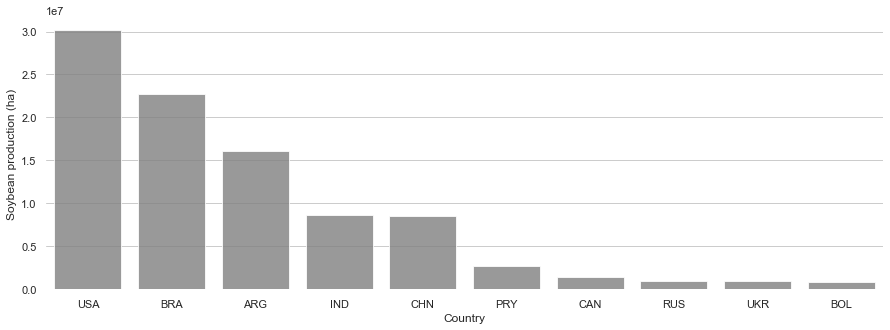

In [21]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize']=(15,5)

# Let's start with a simple barchart to visualise the biggest producers of soybean 
soya_countries = soya_joined.groupby(['iso3', 'name_cntr']).agg({'soyb_a':'sum', 'total_production': 'sum'}).sort_values('soyb_a', ascending = False).reset_index()
top_soya_countries = soya_countries.head(10)

sns.set_color_codes("pastel")
sns.barplot(x = top_soya_countries.iso3, y=top_soya_countries.soyb_a, color="grey", alpha = 0.8)
sns.despine(offset = 5, left=True, bottom=True)
plt.xlabel("Country")
plt.ylabel("Soybean production (ha)")

From this we see that USA, Brazil and Argentina are the top 3 producers of Soybean. Quite head and shoulders above everyone else!

Text(0, 0.5, '% soybean production from total crop prooduction')

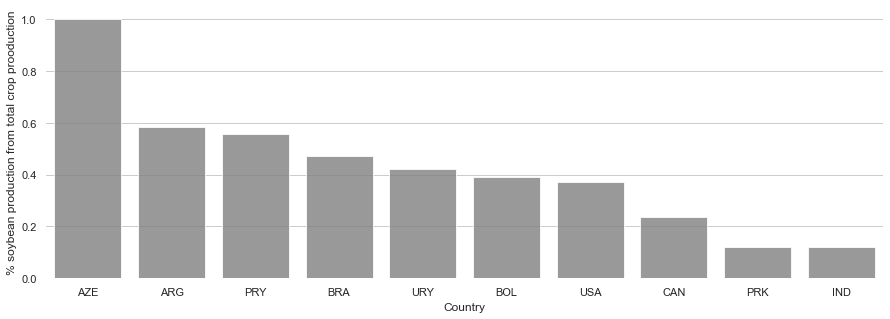

In [22]:
# Now lets see which countries are biggest producers of soybean as % from their total crop production
# i.e which countries are the most reliant of soybean production
soya_countries['soyb_percent'] = soya_countries.soyb_a / soya_countries.total_production
soya_countries.sort_values('soyb_percent', inplace=True, ascending = False)
top_soya_countries = soya_countries.head(10)

sns.set_color_codes("pastel")
sns.barplot(x = top_soya_countries.iso3, y=top_soya_countries.soyb_percent, color="grey", alpha = 0.8)
sns.despine(offset = 5, left=True, bottom=True)
plt.xlabel("Country")
plt.ylabel("% soybean production from total crop prooduction")

From the graph we see that (at least according to this dataset), all of Azerbajdzan's crop production is soybean! But then the latin american countries of Argentina, Paraguay, Brazil, Uruguay and Bolivia all rely quite heavily on seabean production since almost 40-60% of all their crop production is simply soybean.

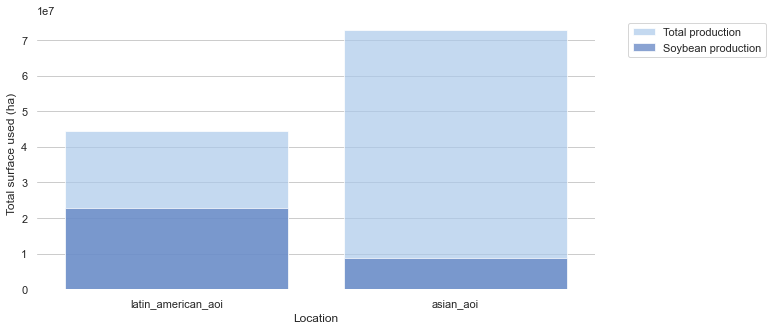

In [27]:
# Let's get a high level overview of our areas of interest!
aoi_level_production = soya_joined.groupby(['location']).agg({'soyb_a':'sum', 'total_production' : 'sum', 'area_ha' : 'min'}).reset_index()
aoi_level_production = aoi_level_production[aoi_level_production.location != "outside_aoi"]
plt.rcParams['figure.figsize']=(10,5)

f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x=aoi_level_production.location,y=aoi_level_production.total_production, order = ['latin_american_aoi', 'asian_aoi'], label = 'Total production', color="b", alpha = 0.7)
sns.set_color_codes("muted")
sns.barplot(x = aoi_level_production.location, y=aoi_level_production.soyb_a, order = ['latin_american_aoi', 'asian_aoi'], label = 'Soybean production', color="b", alpha = 0.7)
sns.despine(offset = 5, left=True, bottom=True)
plt.xlabel("Location")
plt.ylabel("Total surface used (ha)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

Interestingly, from the graph above we see that even tho the latin_american_aoi is bigger in overall size, it's total crop production is smaller than of the asian_aoi. However, soybean is grown much more (~20 million ha) in the latin_american_aoi than in the asian_aoi.

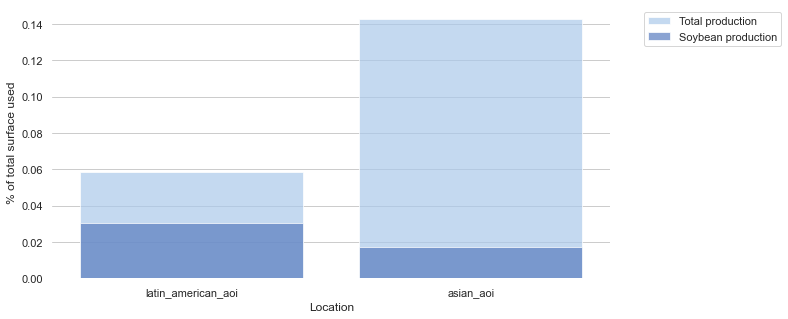

In [28]:
# Because of the interesting dynamic, let's see the above graph as a as a percentage of their total size, 
# i.e. how much of the total area is used for crop production and how much of it is used specifically for soybean production?
aoi_level_production = soya_joined.groupby(['location']).agg({'soyb_a':'sum', 'total_production' : 'sum', 'area_ha' : 'min'}).reset_index()
#proportion of whole surface area used for soybean production
aoi_level_production['soyb_prop_area'] = aoi_level_production.soyb_a / aoi_level_production.area_ha
#proportion of whole surface area used for total crop production
aoi_level_production['total_prod_prop_area'] = aoi_level_production.total_production / aoi_level_production.area_ha
# drop 'outside_aoi' since we do not have the total surface area
aoi_level_production = aoi_level_production[aoi_level_production.location != 'outside_aoi'].sort_values('soyb_prop_area', ascending = False)

plt.rcParams['figure.figsize']=(10,5)

f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x=aoi_level_production.location,y=aoi_level_production.total_prod_prop_area, label = 'Total production', color="b", alpha = 0.7)
sns.set_color_codes("muted")
sns.barplot(x = aoi_level_production.location, y=aoi_level_production.soyb_prop_area, label = 'Soybean production', color="b", alpha = 0.7)
sns.despine(offset = 5, left=True, bottom=True)
plt.xlabel("Location")
plt.ylabel("% of total surface used")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

From the graph above we see that in the latin_american_aoi, only ~ 6% of the area is used for crop production, but around half (~ 3%) of all this is simply used for soybean production! Meanwhile, in the asian_aoi, we see that a much larger areas is dedicated to crop production (~ 14%) but actually only less than 2% is used to grow soybean.

Text(0, 0.5, '% soybean production from total crop production')

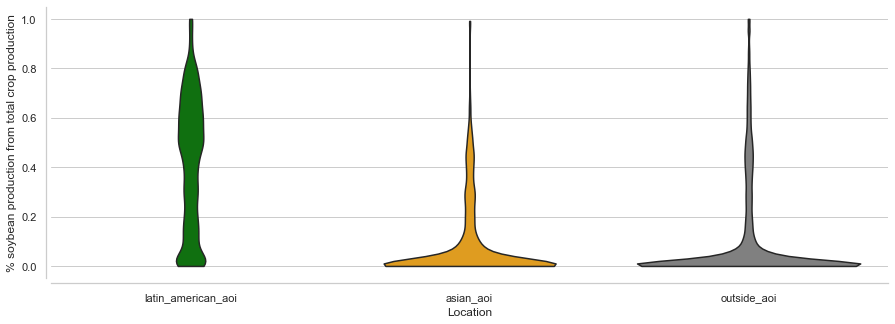

In [30]:
# Let's use a violin plot to get more context on the above graph
# Let's start by seeing the soybean production as % of total crop production across all grids within the two areas of interest plus all others for context
# i.e. is a particular area more prone to use soybean monoculture?
# Note: so now we look at the situation in each 10x10km grid!
plt.rcParams['figure.figsize']=(15,5)

sns.violinplot(x=soya_joined["location"], y=soya_joined['soyb_percent'], order = ['latin_american_aoi', 'asian_aoi', 'outside_aoi'], palette=['green', 'orange', 'grey'], scale = 'area', inner= None, cut = 0)
sns.despine(offset = 5)
plt.xlabel("Location")
plt.ylabel("% soybean production from total crop production")

From the above graph we see:
1. in the latin_american_aoi, soybean production is much more prone to be a monoculture, where within each 10x10km grid, soybean makes up more than 50% of crop production
2. in the asian_aoi, soybean production is much more mixed in with other crops and rarely makes up more than 40% of the total crop production
3. when looking at all the other grids that do not fall into our two areas of interest, we see that they closely resemble the situation seen in our asian_aoi

Text(0, 0.5, '% crop area from total grid area')

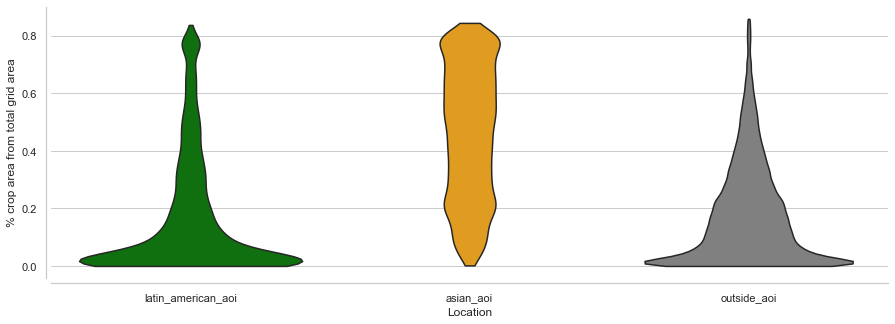

In [31]:
# Let's use another violin plot to see the % of total production in grid across the two areas of interest plus all others for context
# i.e. do the areas of interest differ in their farming "intensity"?
# where a value of 1 means the whole 10x10km grid is used for crop production
sns.violinplot(x=soya_joined["location"], y=soya_joined['total_production_percent'], order = ['latin_american_aoi', 'asian_aoi', 'outside_aoi'], palette=['green', 'orange', 'grey'], scale = 'area', inner= None, cut = 0)
sns.despine(offset = 5)
plt.xlabel("Location")
plt.ylabel("% crop area from total grid area")

From the above graph we see:
1. the farming intensity in latin_american_aoi is relatively low, since in a lot of the grids we see the crop production using only 0-20% of the area
2. the farming intensity in asian_aoi is relatively high, since we see a large proportion of grids having more than half the area dedicated to crop production
3. the farming intensity in the rest of the world resembles the latin_american_aoi ever so slightly, but we also see more grids being 'cleared' for crop production

Text(22.882754513888898, 0.5, '% of whole area dedicated to crop production')

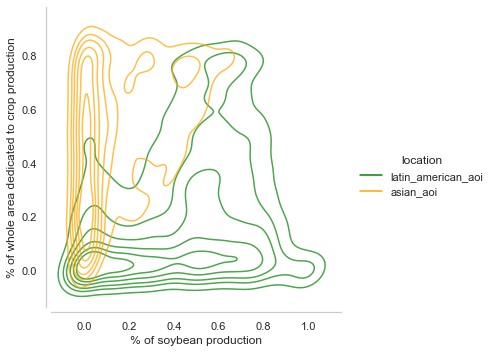

In [32]:
# Putting it together, we can use a density plot comparing the two measures - propensity to grow soybean as 
# monoculture and grow it across the whole 10x10km grid
soya_joined_aois = soya_joined[(soya_joined.location != 'outside_aoi')]

sns.set_style("whitegrid", {'axes.grid' : False})

#f, ax = plt.subplots()
sns.displot(soya_joined_aois, x="soyb_percent", y = 'total_production_percent', hue="location", kind="kde", hue_order = ['latin_american_aoi', 'asian_aoi'], palette=['green', 'orange'], alpha = 0.7, levels = 7)
sns.despine(offset = 5)
plt.xlabel('% of soybean production')
plt.ylabel('% of whole area dedicated to crop production')

The above graph summarises the story from the previous two graphs, in latin_american_aoi we see higher density of grids having high soybean monoculture (high values on x-axis) but not really utilising the full area of the 10x10km grid (low values on y-axis). While the situation is (almost nicely & fittingly) opposite in the asian_aoi - large areas cleared for crop production but not so much soybean.

### Let's now map the grids so we see where they occur

In [36]:
# Because we have so many grids, it would be too chaotic and useless to visualise them all. So let's just visualise 
# the hotspots of where the top 10% of soybean producing grids occur. Let's start with the asian_aoi.
from folium.plugins import HeatMap

asian_soya = soya_joined_aois[soya_joined_aois.location == 'asian_aoi'].sort_values('soyb_a', ascending=False)
asian_soya_top5 = asian_soya[:(int(0.10*len(asian_soya)))]
asian_soya_top5_latlon = list(zip(asian_soya_top5.y, asian_soya_top5.x))

m = folium.Map(location=list([asian_soya_top5.y.mean(), asian_soya_top5.x.mean()]), zoom_start=6, 
               tiles = "https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoia296bWFuYXV0IiwiYSI6ImNqOGU3b2hwdDB4aGczM21veHpyczJ6djcifQ.lPah-oGMKeAD_Z45l_zeaA",
                attr='mapbox')
HeatMap(
    data=asian_soya_top5_latlon,
    min_opacity=0.3,
    max_zoom = 10,
    blur=35,
).add_to(m)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.LayerControl().add_to(m)
m

From the map we can see that the top 10% soybean producing grids form 4 "Hotspots" within the asian_aoi (all occuring in India) - the major one within the triangle of Indore-Bhopal-Kota, the second one around Amravati, the third one south of Mumbai and the 4th one uccuring around Latur (most likely this is in fact connected to the second hotspot).

In [37]:
# Let's now have a look at the latin american aoi.

latam_soya = soya_joined_aois[soya_joined_aois.location == 'latin_american_aoi'].sort_values('soyb_a', ascending=False)
latam_soya_top5 = latam_soya[:(int(0.10*len(asian_soya)))]
latam_soya_top5_latlon = list(zip(latam_soya_top5.y, latam_soya_top5.x))

m = folium.Map(location=list([latam_soya_top5.y.mean(), latam_soya_top5.x.mean()]), 
               zoom_start=5, tiles = "https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoia296bWFuYXV0IiwiYSI6ImNqOGU3b2hwdDB4aGczM21veHpyczJ6djcifQ.lPah-oGMKeAD_Z45l_zeaA",
                attr='mapbox')

HeatMap(
    data=latam_soya_top5_latlon,
    min_opacity=0.3,
    max_zoom = 10,
    blur=25,
).add_to(m)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.LayerControl().add_to(m)
m

In the latin_american_aoi, we also see 4 hotspots of soybean production. One huge area in the southern Brazil and eastern Paraguay, then another in the southern part of the Amazon (North of Cuiabá), and then two smaller patches - one south-west of Brasília and one in Argentina around San Miguel de Tucumám.

### WOULD LOVE TO HAVE DONE:

- add forestry data to see proximity of grids to forest (as a measure of 'potential for ecological damage')
- add and explore landgrabbing data to see if there are any links with recently landgrabbed areas and soybean production
- overlay some index/map of climate change data (as granular as possible) to see if/which areas of soybean production will be running into issues due to climate change

... all of which would be relevant with regards to supply chain sustainability and security.

### Tableau dashboard for more data exploration

Day-to-day I work a lot with Tableau so I have brought the data into this tool and made a dashboard that explores and visualizes the soybean production data:

https://public.tableau.com/app/profile/radoslav.kozma/viz/SoybeanChallenge/SoyDash?publish=yes

### Spotify playlist while coding

Inspirational 'Tuareg Desert Blues'

https://open.spotify.com/playlist/5z50ZjGDY64N7ep63V9nSI?si=aa09fd908cbe4aa9

## THANK YOU!
Rado

In [123]:
# Save the files for easier retrieval
# data for just asian_aoi
asian_soya.to_file('asian_soya.geojson', driver='GeoJSON')
# data for latin_american_aoi
latam_soya.to_file('latam_soya.geojson', driver='GeoJSON')
# data for all points
soya_joined.to_file('soya_joined.geojson', driver='GeoJSON')